In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


data = 'ecfp'
group_size = 1
num_exps = 120
num_repeats_per_exp = 1

policies = [
    'ens jensen greedy',
    'classical ens',
    'greedy',
    # 'round robin greedy',
]
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 500

basepath = os.path.join('../../data/results', data)


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            labels = np.loadtxt(
                os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                dtype=int
            ).flatten() - 1

            utilities[p_ind, exp_ind, i, :] = log_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [3]:
utilities.shape

(3, 120, 1, 501)

In [4]:
utilities[..., -1].mean(axis=(1, 2))

array([4.91396496, 4.9697297 , 5.00978162])

ens jensen greedy: 4.9140
classical ens: 4.9697
greedy: 5.0098


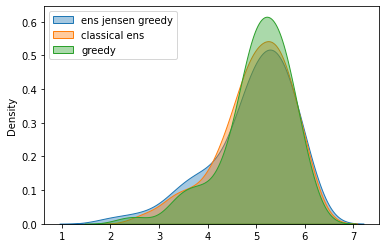

In [5]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=policy)
    
plt.legend(loc='upper left');

In [6]:
print(utilities.shape)
utilities

(3, 120, 1, 501)


array([[[[0.69314718, 0.69314718, 1.09861229, ..., 5.74300319,
          5.74300319, 5.74300319]],

        [[0.69314718, 0.69314718, 0.69314718, ..., 5.68357977,
          5.68357977, 5.68357977]],

        [[0.69314718, 0.69314718, 0.69314718, ..., 4.97673374,
          4.97673374, 4.97673374]],

        ...,

        [[0.69314718, 1.09861229, 1.38629436, ..., 5.45958551,
          5.45958551, 5.45958551]],

        [[0.69314718, 0.69314718, 0.69314718, ..., 4.65396035,
          4.66343909, 4.66343909]],

        [[0.69314718, 0.69314718, 1.09861229, ..., 5.41164605,
          5.41164605, 5.41164605]]],


       [[[0.69314718, 0.69314718, 1.09861229, ..., 5.68357977,
          5.68357977, 5.68357977]],

        [[0.69314718, 0.69314718, 0.69314718, ..., 5.65599181,
          5.65948222, 5.66296048]],

        [[0.69314718, 0.69314718, 0.69314718, ..., 4.97673374,
          4.97673374, 4.97673374]],

        ...,

        [[0.69314718, 1.09861229, 1.38629436, ..., 5.45103845,
       

In [7]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(3, 120, 501)


array([[[0.69314718, 0.69314718, 1.09861229, ..., 5.74300319,
         5.74300319, 5.74300319],
        [0.69314718, 0.69314718, 0.69314718, ..., 5.68357977,
         5.68357977, 5.68357977],
        [0.69314718, 0.69314718, 0.69314718, ..., 4.97673374,
         4.97673374, 4.97673374],
        ...,
        [0.69314718, 1.09861229, 1.38629436, ..., 5.45958551,
         5.45958551, 5.45958551],
        [0.69314718, 0.69314718, 0.69314718, ..., 4.65396035,
         4.66343909, 4.66343909],
        [0.69314718, 0.69314718, 1.09861229, ..., 5.41164605,
         5.41164605, 5.41164605]],

       [[0.69314718, 0.69314718, 1.09861229, ..., 5.68357977,
         5.68357977, 5.68357977],
        [0.69314718, 0.69314718, 0.69314718, ..., 5.65599181,
         5.65948222, 5.66296048],
        [0.69314718, 0.69314718, 0.69314718, ..., 4.97673374,
         4.97673374, 4.97673374],
        ...,
        [0.69314718, 1.09861229, 1.38629436, ..., 5.45103845,
         5.45103845, 5.45103845],
        [0.6

4.7574455021468784 5.070484427166082
0.07825973125480079
4.832909120156167 5.106550282561713
0.06841029060138659
4.878503269258736 5.141059970870221
0.06563917540287134


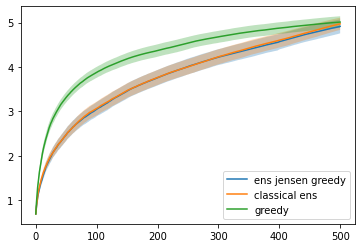

In [8]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print((upper[-1] - lower[-1]) / 4)
    
plt.legend();